# PLEASE NOTE:
In order for inference to run properly as demonstrated for this model, the whole program needs to be executed. This execution of the the program upto and include the inference part does not take long. The rest of the code however that contains the calculation of percentage of landmarks for each class, takes about 10 minutes.

## Problem Statement
This project aims to mitigate the communication challenges faced by the deaf and hard of hearing community by employing deep learning techniques to classify images of the sign language alphabet into their respective letter labels and display them to the user. 

By leveraging the sophisticated capabilities of deep learning and neural networks, the project presents two model that are designed to interpret and translate sign language gestures into text, thereby enhancing accessibility in digital communication between deaf and non-deaf people. The project aims to create a tool (the best of the two approaches) that can be integrated into various digital platforms, ultimately bridging the communication gap between individuals who rely in sign langauge and those who dont have experience with it to promoting inclusivity in digital interactions for those who rely on sign language.

This is approach 2 of 2, a Key Points Extractor and a Standard Neural Network.

In [7]:
# README CELL 2.1
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import sklearn.metrics as metrics
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import ImageFolder
import pandas as pd
import mediapipe as mp

from sklearn.preprocessing import MinMaxScaler

The code in the cell below defines our KeyPointsNet neural network model and architecture for keypoint-based gesture classification. It consists of two fully connected layers with batch normalization, ReLU activation, and dropout for regularization. The input size is 21 (keypoints) multiplied by 3 (coordinates) which is a final input size of 63 values, and the output layer has 29 nodes corresponding to different gesture classes. The model utilizes log-softmax activation for classification at the output layer. In the forward method, input data is passed through the sequential layers to produce the model's prediction.

In [8]:
# README CELL 2.2
class KeyPointsNet(nn.Module):
    def __init__(self):
        super(KeyPointsNet, self).__init__()
        hidden_node_count = 150
        self.main = nn.Sequential(
            nn.Linear(21*3, hidden_node_count),
            nn.BatchNorm1d(hidden_node_count),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_node_count, 29),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        output = self.main(x)
        return output

Below is a diagram of our KeyPointsNet model architecture to assist in visualization.

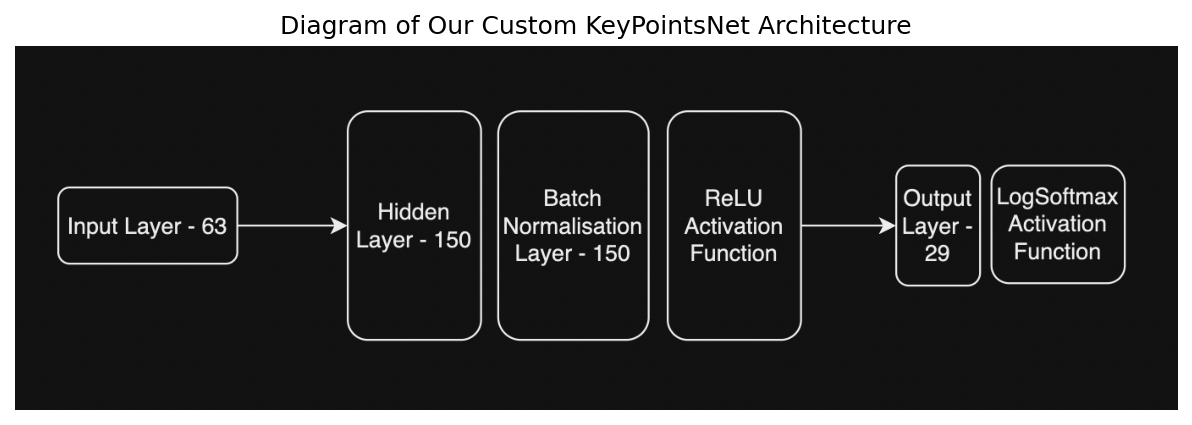

In [3]:
example_image = cv2.imread('keypointsNetModel_diagram.png')
plt.figure(figsize=(10, 10), dpi=150)
plt.title("Diagram of Our Custom KeyPointsNet Architecture")
plt.axis('off')
plt.imshow(example_image)
plt.show()

The code in the cell below defines a train function which is designed for training a neural network (net) using a specified device, data loader (train_loader), optimizer, and for a given epoch. It iterates through batches for a given epoch, computes the cross-entropy loss, performs backpropagation, and updates the model parameters. The function prints training progress every 100 batches, including the loss for each 100th batch. It also calculates and returns the training accuracy at the end of each epoch based on the number of correct predictions. The training accuracy, loss, and progress are printed for every epoch. The function skeleton was taken from COMP9444, Assignment 1 (23T3) and COMP9444, Lecture 2b (PyTorch) and parts of it were changed to suit our needs when solving our problem. These parts include:
- The loss function being changed to Cross Entropy Loss.
- Changing the frequency of logging training progress to a lower frequency to avoid output clutter.
- Printing the loss and training accuracy at the end of each epoch.

In [3]:
def train(net, device, train_loader, optimizer, epoch):
    net.train()
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = F.cross_entropy(output, target)                 
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    accuracy = 100*correct/total
    if epoch % 1 == 0:
        print('Train Epoch:%5d loss: %6.4f acc: %5.2f' % (epoch,loss.item(),accuracy))
    return accuracy

The code in the cell below defines a test function which evaluates the performance of a neural network (net) on a test dataset using a specified device and data loader (test_loader). It sets the model to evaluation mode, initializes a confusion matrix, and computes the test loss and accuracy. The function iterates through the test dataset, calculates the cross-entropy loss, and updates the confusion matrix. It then prints the confusion matrix and overall test accuracy. The model is set back to training mode at the end. The confusion matrix provides a detailed breakdown of the model's performance across different classes, aiding in the assessment of classification errors.

In [4]:
def test(net, device, test_loader):
    net.eval()        
    conf_matrix = np.zeros((29,29))      
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            test_loss = F.cross_entropy(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            conf_matrix = conf_matrix + metrics.confusion_matrix(target.cpu(),pred.cpu(),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28])
        np.set_printoptions(precision=4, suppress=True)
        print(type(conf_matrix))
        print(conf_matrix)
        net.train()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

The code in the cell below loads keypoints data for American Sign Language (ASL) gestures from CSV files, where each file corresponds to a different gesture class. The data is split into two subsets: 80% for training (data_80) and 20% for testing (data_20). The script normalizes the features of both subsets using Min-Max scaling to ensure consistency in comparison to our CNN model and its performance. The file paths and labels are defined based on the specified gesture classes. Additionally, the script excludes the "nothing" class from the training set. This is due to the absence of any hands in the images of the "nothing" class and as a result the absence of any possible keypoints to extract. The resulting dataframes (data_80 and data_20) are then ready for use in training and testing using KeyPointsNet model.

In [9]:
# README CELL 2.3
# Load Data

labels = ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
file_names = []

for i in range(0,29):
    file_names.append(f'keypointCsvFiles/class_{i}_label_{labels[i]}_keypoints_matrix')

file_names.remove('keypointCsvFiles/class_15_label_nothing_keypoints_matrix')

data_20 = pd.DataFrame()
data_80 = pd.DataFrame()

for file_name in file_names:
    df = pd.read_csv(file_name,header=None)

    df = df[:500]

    df_20 = df.sample(frac=0.2)
    df_80 = df.drop(df_20.index)

    data_80 = pd.concat([data_80, df_80], ignore_index=True)
    data_20 = pd.concat([data_20, df_20], ignore_index=True)

# normalising the data to same range as cnn model to ensure consistent and fair comparison
scaler = MinMaxScaler(feature_range=(-0.5, 0.5))

data_80.iloc[:, :-1] = scaler.fit_transform(data_80.iloc[:, :-1])
data_20.iloc[:, :-1] = scaler.transform(data_20.iloc[:, :-1])


The code in the cell below defines a custom PyTorch dataset class, DataFrameDataset, for handling the training and testing datasets. This class takes a pandas dataframe as input and converts its features and labels into PyTorch tensors. The __len__ method returns the length of the dataset, and the __getitem__ method retrieves a specific data sample (features and corresponding label) at a given index. Two instances of this dataset class, train_dataset and test_dataset, are then created using the training (data_80) and testing (data_20) dataframes, respectively. These datasets are intended for use in training and evaluating machine learning models, such as the previously defined KeyPointsNet model.

In [7]:
# Data preparation

class DataFrameDataset(Dataset):
    def __init__(self, dataframe):
        self.data = torch.tensor(dataframe.iloc[:, :-1].values).float()
        self.labels = torch.tensor(dataframe.iloc[:, -1].values).long()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]

        return x, y
    

train_dataset = DataFrameDataset(data_80)
test_dataset = DataFrameDataset(data_20)

The code in the cell below sets up the main components for training and testing a machine learning model. It determines the device (CPU or GPU) available for computation and initializes data loaders for training and testing using the previously defined datasets (train_dataset and test_dataset). The neural network model (net), an instance of the KeyPointsNet class, is created and moved to the specified device. Stochastic Gradient Descent (SGD) is chosen as the optimizer with a learning rate of 0.01 and momentum of 0.95. The variable epochs is set to 13, indicating the number of times the entire training dataset will be passed through the model during training. 

In [8]:
# Main

device = 'cpu'

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using GPU...")
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU...")

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True) 
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

net = KeyPointsNet().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.95)

epochs = 13

GPU not available. Using CPU...


# Results

The test results indicate that the KeyPointsNet model achieved a remarkably low average loss of 0.0000, suggesting precise predictions on the test set. The accuracy of 97% signifies that the model correctly classified 2,641 out of 2,719 samples. This high accuracy underscores the effectiveness of the model in generalizing well to unseen data, demonstrating its robustness in recognizing sign language gestures based on the extracted keypoints.

In [9]:
for epoch in range(1, epochs + 1):
    train(net, device, train_loader, optimizer, epoch)
    test(net, device, test_loader)

Train Epoch: 1 [0/10879 (0%)]	Loss: 3.545589
Train Epoch: 1 [6400/10879 (59%)]	Loss: 0.556755
Train Epoch:    1 loss: 0.3681 acc: 67.43
<class 'numpy.ndarray'>
[[ 95.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   4.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.  98.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   1.   3.  95.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   2.   0.  86.   0.   0.   0.   0.   0.   0.   0.   0.   1.
    1.   0.   0.   0.   3.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
    0.  

The code in the cell below just saves the weights of the trained model so we can load it again and use it when needed, just like we will be doing in the following inference section.

In [10]:
# Assuming 'net' is your model
torch.save(net.state_dict(), 'OUTPUT/keypoints_trained_model_weights.pth')

The below map_integer_to_string(key) function is just a mapping function from the class numbers to the class character labels.

In [10]:
# README CELL 2.4
def map_integer_to_string(key):
    mapping = {
        0: "A",
        1: "B",
        2: "C",
        3: "D",
        4: "del",
        5: "E",
        6: "F",
        7: "G",
        8: "H",
        9: "I",
        10: "J",
        11: "K",
        12: "L",
        13: "M",
        14: "N",
        15: "nothing",
        16: "O",
        17: "P",
        18: "Q",
        19: "R",
        20: "S",
        21: "space",
        22: "T",
        23: "U",
        24: "V",
        25: "W",
        26: "X",
        27: "Y",
        28: "Z"
    }
    
    return mapping.get(key)

# Inference section

The code in the cell below defines a function, get_hand_keypoints_from_image, to extract hand keypoints from a given image using the MediaPipe library for hand tracking. The function takes the image file path and a scaler for normalization as inputs. It loads the image, converts it to RGB format, and uses the MediaPipe Hands module to detect hand landmarks. If landmarks are found, it extracts their coordinates, normalizes them using the specified scaler, and converts them into a PyTorch tensor. The function returns the tensor containing the normalized keypoints. If no hand landmarks are detected or there is an issue loading the image, corresponding informative messages are returned. This function can be utilized for obtaining keypoints from individual images for further processing with the KeyPointsNet model.

In [11]:
# README CELL 2.5
# Function to extract keypoints from 1 image

# Define same data transform to ensure consistency.
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.7)

def get_hand_keypoints_from_image(image_path, scaler):
    keypoints_list = []

    # Load the image
    image = cv2.imread(image_path)
    if image is not None:
        # Convert the image color from BGR to RGB.
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        # If hand landmarks are detected, extract them.
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                keypoints = []
                for lm in hand_landmarks.landmark:
                    keypoints.extend([lm.x * 200, lm.y * 200, lm.z * 200])
                keypoints_list.append(keypoints)
        else:
            return "No hand landmarks detected"
    else:
        return "Unable to load image"
    
    keypoints_array = np.array(keypoints_list)

    keypoints_normalized = scaler.transform(keypoints_array)

    # Convert the numpy array to a PyTorch tensor
    keypoints_tensor = torch.tensor(keypoints_normalized).float()

    return keypoints_tensor

The code initializes a new instance of the KeyPointsNet model and loads pre-trained weights into it. The model is then set to evaluation mode (model.eval()). 

In [12]:
# README CELL 2.6
# instatiate model and initialise with KeyPointsNet object
model = KeyPointsNet()

# Loading trained model weights
model.load_state_dict(torch.load('OUTPUT/keypoints_trained_model_weights.pth'))

# DO NOT COMMENT THIS CODE OUT AS IT SETS MODEL TO EVALUATION MODE
model.eval()  

KeyPointsNet(
  (main): Sequential(
    (0): Linear(in_features=63, out_features=150, bias=True)
    (1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=150, out_features=29, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

## Correctly Predicted Inferences

In [13]:
# inference 1 trial
keypoints1 = get_hand_keypoints_from_image('../datasets/inference_test_data/B_test.jpg', scaler=scaler)

if not isinstance(keypoints1, torch.Tensor):
   print(keypoints1)
else:
   with torch.no_grad():
       prediction = model(keypoints1)

   # Get the predicted index
   predicted_index = torch.argmax(prediction, dim=1)

   print(f'Predicted Label: {map_integer_to_string(predicted_index.item())}')
   print(f'Predicted Class: {predicted_index.item()}')

Predicted Label: B
Predicted Class: 1


![alternative text](../datasets/inference_test_data/B_test.jpg)

In [14]:
# inference 2 trial
keypoints1 = get_hand_keypoints_from_image('../datasets/inference_test_data/I_test.jpg', scaler=scaler)

if not isinstance(keypoints1, torch.Tensor):
   print(keypoints1)
else:
   with torch.no_grad():
       prediction = model(keypoints1)

   # Get the predicted index
   predicted_index = torch.argmax(prediction, dim=1)

   print(f'Predicted Label: {map_integer_to_string(predicted_index.item())}')
   print(f'Predicted Class: {predicted_index.item()}')

Predicted Label: I
Predicted Class: 9


![alternative text](../datasets/inference_test_data/I_test.jpg)

In [18]:
# inference 3 trial
keypoints1 = get_hand_keypoints_from_image('../datasets/inference_test_data/J_test.jpg', scaler=scaler)

if not isinstance(keypoints1, torch.Tensor):
   print(keypoints1)
else:
   with torch.no_grad():
       prediction = model(keypoints1)

   # Get the predicted index
   predicted_index = torch.argmax(prediction, dim=1)

   print(f'Predicted Label: {map_integer_to_string(predicted_index.item())}')
   print(f'Predicted Class: {predicted_index.item()}')

Predicted Label: J
Predicted Class: 10


![alternative text](../datasets/inference_test_data/J_test.jpg)


In [19]:
# inference 4 trial
keypoints1 = get_hand_keypoints_from_image('../datasets/inference_test_data/F_test.jpg', scaler=scaler)

if not isinstance(keypoints1, torch.Tensor):
   print(keypoints1)
else:
   with torch.no_grad():
       prediction = model(keypoints1)

   # Get the predicted index
   predicted_index = torch.argmax(prediction, dim=1)

   print(f'Predicted Label: {map_integer_to_string(predicted_index.item())}')
   print(f'Predicted Class: {predicted_index.item()}')

Predicted Label: F
Predicted Class: 6


![alternative text](../datasets/inference_test_data/F_test.jpg)

## Inferences With No Landmarks Detected

In [20]:
# inference 5 trial
keypoints1 = get_hand_keypoints_from_image('../datasets/inference_test_data/C_test.jpg', scaler=scaler)

if not isinstance(keypoints1, torch.Tensor):
   print(keypoints1)
else:
   with torch.no_grad():
       prediction = model(keypoints1)

   # Get the predicted index
   predicted_index = torch.argmax(prediction, dim=1)

   print(f'Predicted Label: {map_integer_to_string(predicted_index.item())}')
   print(f'Predicted Class: {predicted_index.item()}')

No hand landmarks detected


![alternative text](../datasets/inference_test_data/C_test.jpg)

In [21]:
# inference 6 trial
keypoints1 = get_hand_keypoints_from_image('../datasets/inference_test_data/D_test.jpg', scaler=scaler)

if not isinstance(keypoints1, torch.Tensor):
   print(keypoints1)
else:
   with torch.no_grad():
       prediction = model(keypoints1)

   # Get the predicted index
   predicted_index = torch.argmax(prediction, dim=1)

   print(f'Predicted Label: {map_integer_to_string(predicted_index.item())}')
   print(f'Predicted Class: {predicted_index.item()}')

No hand landmarks detected


![alternative text](../datasets/inference_test_data/D_test.jpg)

# Challenges Faced

The cell below iterates through 29 classes representing American Sign Language letters in a dataset. For each class, it calculates the percentage of successfully landmarked images by extracting keypoints from images and using a neural network for prediction.

In [ ]:
import os

for i in range(0, 29):
    landmarked, total, wrong = 0, 0, 0
    letter = str(map_integer_to_string(i))
    filename = ('../datasets/training_data/'+letter+'/'+letter)
    for i in range(3, 3001):
        if os.path.isfile(filename+str(i)+'.jpg'):
            total += 1
            keypoints1 = get_hand_keypoints_from_image(filename+str(i)+'.jpg', scaler=scaler)
            if not isinstance(keypoints1, torch.Tensor):
                # print(keypoints1)
                continue
            else:
                with torch.no_grad():
                    prediction = model(keypoints1)
                predicted_index = torch.argmax(prediction, dim=1)
                pred_letter = map_integer_to_string(predicted_index.item())
                landmarked += 1
                # print(f'Predicted Label: {map_integer_to_string(predicted_index.item())}')
                # print(f'Predicted Class: {predicted_index.item()}')
                if pred_letter != letter:
                    wrong += 1
    print(f"Percentage of Landmarked '{letter}' images: {((100*landmarked)/total)}%")
    #print(f"Percentage of Correctly Predicted '{letter}' images: {(100-((100*wrong)/landmarked))}%")

Percentage of Landmarked 'A' images: 68.9%
Percentage of Landmarked 'B' images: 70.9%
Percentage of Landmarked 'C' images: 59.7%
Percentage of Landmarked 'D' images: 77.1%
Percentage of Landmarked 'del' images: 46.6%
Percentage of Landmarked 'E' images: 73.4%
Percentage of Landmarked 'F' images: 92.1%
Percentage of Landmarked 'G' images: 75.5%
Percentage of Landmarked 'H' images: 77.1%
Percentage of Landmarked 'I' images: 75.7%
Percentage of Landmarked 'J' images: 81.0%
Percentage of Landmarked 'K' images: 85.6%
Percentage of Landmarked 'L' images: 81.1%
Percentage of Landmarked 'M' images: 38.8%
Percentage of Landmarked 'N' images: 33.3%
Percentage of Landmarked 'nothing' images: 0.0%
Percentage of Landmarked 'O' images: 72.0%
Percentage of Landmarked 'P' images: 63.9%
Percentage of Landmarked 'Q' images: 64.2%
Percentage of Landmarked 'R' images: 80.2%
Percentage of Landmarked 'S' images: 81.3%
Percentage of Landmarked 'space' images: 40.3%
Percentage of Landmarked 'T' images: 75.5%


The output indicates the percentage of successfully landmarked images for each letter. Notably, some letters achieve high percentages, indicating effective keypoint extraction, while others show lower rates. The lower percentages for certain letters suggest that the dataset may pose challenges for accurate keypoint extraction, especially in those specific cases. 

# Discussion and Analysis of Results

## Comparison With CNN Model

One notable strength of the KeyPointsNet model is its high accuracy, reaching a 97% final epoch correct prediction rate when keypoints are successfully detected in an image. This indicates the model's robustness in capturing essential information from the hand gestures, leading to accurate classification. Notably, the model performs well in predicting the ASL gestures for letters I and J, showcasing its capability to handle subtle differences and dynamic gestures. Unlike the CNN model which gets confused between I and J due to the similarities in signs.

In contrast to the CNN model, the KeyPointsNet model encounters difficulty in accurately classifying images corresponding to classes C and D. This discrepancy arises from the KeyPointsNet model's inability to extract meaningful key points in these instances with respect to these gestures. The CNN model, on the other hand, successfully predicts these classes, showcasing its ability to capture and interpret the distinct features of these gestures even in cases where key point extraction is challenging for the KeyPointsNet model. The KeyPointsNet model also lacks the ability to classify images with no discernible key points accurately. Specifically, when there are no keypoints to extract from an input image, the KeyPointsNet model cannot correctly classify images belonging to the "nothing" class.

## Conclusion and Areas of Improvement

To enhance the KeyPointsNet model's performance, particularly in scenarios with challenging hand configurations, one potential avenue is to explore more sophisticated key point extraction techniques or employ a dataset with clearer finger distinctions. Additionally, augmenting the dataset with diverse hand configurations and ensuring a balance of static and dynamic gestures could contribute to improved generalization.

In conclusion, while the KeyPointsNet model demonstrates high accuracy when key points are successfully detected, challenges in the dataset and the inability to handle images without distinguishable keypoints suggest areas for improvement. Addressing these challenges through dataset refinement and advanced key point extraction techniques could elevate the model's overall performance in ASL prediction.